In [3]:
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
root_dir = '../../data/'

In [4]:
pd.set_option('display.max_columns', None)


In [5]:
# aed_dir = root_dir + 'raw/aed_locations/aed_locations.parquet.gzip'

# aed_pq = pq.read_table(aed_dir)
# aed_df = aed_pq.to_pandas()
# aed_df.head()

In [7]:
aed_dir = root_dir + "raw/aedCoordonate.csv"

def clean_column_names(df):
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    return df

# df = pq.read_table(df)
aed_df = pd.read_csv(aed_dir)
aed_df["('Latitude', 'Longitude')"] = aed_df["('Latitude', 'Longitude')"].str.replace(
    r"[\(\)]", "", regex=True
)
aed_df[["latitude", "longitude"]] = aed_df["('Latitude', 'Longitude')"].str.split(
    ", ", expand=True
)

aed_df["postal_code"] = aed_df["postal_code"].astype("Int64")
aed_df["latitude"] = aed_df["latitude"].astype(np.float64)
aed_df["longitude"] = aed_df["longitude"].astype(np.float64)
aed_df = clean_column_names(aed_df)

aed_df = aed_df.loc[
    :,
    [
        "id",
        "type",
        "address",
        "number",
        "postal_code",
        "municipality",
        "province",
        "public",
        "available",
        "hours",
        "latitude",
        "longitude",
    ],
]
aed_df.dropna(subset=["id", "latitude", "longitude"], inplace=True)

In [8]:
aed_df.id.isna().sum()

0

In [9]:
# df.to_csv(root_dir + "/uri_aed.csv")

In [10]:
# import requests

# def get_lat_lon_from_address(address):
#     base_url = "https://nominatim.openstreetmap.org/search"
#     params = {
#         "q": address,
#         "format": "json"
#     }
#     response = requests.get(base_url, params=params)
#     data = response.json()
    
#     if response.status_code == 200 and len(data) > 0:
#         location = data[0]
#         return location['lat'], location['lon']
#     else:
#         print("Error: Unable to geocode address")
#         return None, None

# # lat, lon = get_lat_lon_from_address(address)

In [11]:
# aed_dir = root_dir + 'raw/aed_locations/aed_locations.parquet.gzip'

# aed_df = pq.read_table(aed_dir)
# aed_df = aed_df.to_pandas()
# aed_df = aed_df.dropna(subset=["id"])
# aed_df = aed_df.dropna(subset=["latitude"])
# aed_df = aed_df.dropna(subset=["longitude"])
# aed_df.shape
# aed_df.head()

In [12]:
# import requests
# api_key = "pk.585827610ef03b03ec46759d28aafb63"
# def get_lat_lon_from_address(address, api_key):
#     base_url = "https://us1.locationiq.com/v1/search.php"
#     params = {
#         "key": api_key,
#         "q": address,
#         "format": "json"
#     }
#     response = requests.get(base_url, params=params)
#     data = response.json()
    
#     if response.status_code == 200 and len(data) > 0:
#         location = data[0]
#         return location['lat'], location['lon']
#     else:
#         print("Error: Unable to geocode address")
#         return None, None

# lat, lon = get_lat_lon_from_address(address, api_key)

In [56]:
directory = root_dir + "raw/interventions"

interventions_df = pq.read_table(directory + "/interventions_bxl2.parquet.gzip")
interventions_df = interventions_df.to_pandas()
interventions_df = clean_column_names(interventions_df)

try:
    interventions_df = interventions_df.rename(columns={'eventtype_and_eventlevel': 'eventtype_trip'})
except KeyError:
    interventions_df.dropna(subset=["eventtype_and_eventlevel"], inplace=True)
    
interventions_df.dropna(subset=["eventtype_trip"], inplace=True)
interventions_df = interventions_df.loc[
    interventions_df["eventtype_trip"].str.contains("P003"), :
]

In [57]:
interventions_df

,mission_id,t0,cityname_intervention,longitude_intervention,latitude_intervention,description_nl,ic_description_nl,eventtype_trip,creationtime,number_of_transported_persons,permanence_long_name_nl,permanence_long_name_fr,permanence_short_name_nl,permanence_short_name_fr,service_name_nl,service_name_fr,cityname_permanence,streetname_permanence,housenumber_permanence,latitude_permanence,longitude_permanence,vector_type_nl,vector_type_fr,name_destination_hospital,cityname_destination_hospital,streetname_destination_hospital,housenumber_destination_hospital,abandon_reason_nl,abandon_reason_fr,t1,t2,t3,t4,t5,t6,t7
808,20221530374,02JUN22:20:11:21,1030 schaerbeek (schaerbeek),4.398207e+10,5.084949e+10,Nieuwe melding,Medisch,P003 N01 - HARTSTILSTAND - DOOD - OVERLEDEN,02JUN22:20:14:34,NaN,ZW CITE2,AMB CITE2,A-CIT2,A-CIT2,CITE (MED),CITE (MED),1000 brussel (brussel),rue vesale;vesaliusstraat,NaN,5.085138e+10,4.364098e+10,AMB,AMB,None,None,None,None,Dood Ter Plaatse,DCD,02JUN22:20:14:55,02JUN22:20:16:53,None,None,None,02JUN22:20:27:42,02JUN22:20:50:13
809,20221530374,02JUN22:20:11:21,1030 schaerbeek (schaerbeek),4.398207e+10,5.084949e+10,Nieuwe melding,Medisch,P003 N01 - HARTSTILSTAND - DOOD - OVERLEDEN,02JUN22:20:14:34,NaN,MUG SCHAARBEEK1,SMUR SCHAERBEEK1,M-SCH1,M-SCH1,Schaerbeek (MED),Schaerbeek (MED),1030 schaarbeek (schaarbeek),avenue britsiers;britsierslaan,151370.0,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1074,20221540196,03JUN22:11:46:26,1000 bruxelles (bruxelles),4.343397e+10,5.084320e+10,Nieuwe melding,Medisch,P003 N01 - HARTSTILSTAND - DOOD - OVERLEDEN,03JUN22:11:48:05,NaN,ZW HSP-1,AMB HSP-1,A-HSP1,A-HSP1,HSP (AMB),HSP (AMB),1000 brussel (brussel),rue haute;hoogstraat,NaN,5.083563e+10,4.347475e+10,AMB,AMB,None,None,None,None,Dood Ter Plaatse,DCD,03JUN22:11:48:46,03JUN22:11:50:28,03JUN22:11:54:26,None,None,03JUN22:12:38:18,03JUN22:13:02:52
1075,20221540196,03JUN22:11:46:26,1000 bruxelles (bruxelles),4.343397e+10,5.084320e+10,Nieuwe melding,Medisch,P003 N01 - HARTSTILSTAND - DOOD - OVERLEDEN,03JUN22:11:48:06,NaN,MUG HSP 1,SMUR HSP 1,M-HSP,M-HSP,HSP (MED),HSP (MED),1000 bruxelles (bruxelles),rue haute;hoogstraat,148510.0,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1622,20221550234,04JUN22:16:11:01,1020 bruxelles (laeken),4.347456e+10,5.088146e+09,Nieuwe melding,Medisch,P003 N01 - HARTSTILSTAND - DOOD - OVERLEDEN,04JUN22:16:12:25,NaN,ZW1 STAF,AMB1 EM,A-EM1,A-EM1,Heliport (MED),Heliport (MED),1000 brussel (brussel),helihavenlaan,148816.0,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36258,20222435247,31AUG22:17:55:56,1000 brussel (brussel),4.389640e+10,5.084106e+10,Nieuwe melding,Medisch,P003 N01 - HARTSTILSTAND - DOOD - OVERLEDEN,31AUG22:17:58:21,NaN,MUG DELTA,SMUR DELTA,M-DLT,M-DLT,Delta (SMUR),Delta (SMUR),1160 oudergem (oudergem),boulevard du triomphe;triomflaan,201.0,5.081693e+10,4.400286e+09,MUG,SMUR,None,None,None,None,None,None,31AUG22:17:58:31,31AUG22:18:01:05,31AUG22:18:06:07,None,None,31AUG22:18:30:18,31AUG22:18:58:30
36414,20222445069,01SEP22:08:35:12,1000 bruxelles (bruxelles),4.362110e+10,5.084402e+09,Nieuwe melding,Medisch,P003 N01 - HARTSTILSTAND - DOOD - OVERLEDEN,01SEP22:08:37:53,NaN,MUG STJEAN,SMUR STJEAN,M-SJ,M-SJ,STJEAN (MED),STJEAN (MED),1000 brussel (brussel),rue des cendres;asstraat,5.0,5.085393e+10,4.359311e+10,MUG,SMUR,None,None,None,None,None,None,01SEP22:08:38:46,01SEP22:08:40:13,01SEP22:08:44:53,None,None,01SEP22:08:45:12,01SEP22:08:52:00
36415,20222445069,01SEP22:08:35:12,1000 bruxelles (bruxelles),4.362110e+10,5.084402e+09,Nieuwe melding,Medisch,P003 N01 - HARTSTILSTAND - DOOD - OVERLEDEN,01SEP22:08:37:53,NaN,ZW CITE2,AMB CITE2,A-CIT2,A-CIT2,CITE (MED),CITE (MED),1000 brussel (brussel),rue vesale;vesaliusstraat,NaN,5.085138e+10,4.364098e+1

In [9]:
import os

# Specify the directory path
directory = root_dir + "raw/interventions"

list_of_file_directories = []
for filename in os.listdir(directory):
    if filename.endswith(".parquet.gzip"):
        list_of_file_directories.append(root_dir + "raw/interventions/" + filename)


interventions_df = pq.read_table(list_of_file_directories)
interventions_df = interventions_df.to_pandas()
try:
    interventions_df = interventions_df.rename(columns={'eventtype_and_eventlevel': 'eventtype_trip'})
except KeyError:
    interventions_df.dropna(subset=["eventtype_and_eventlevel"], inplace=True)
interventions_df = clean_column_names(interventions_df)    

interventions_df.dropna(subset=["eventtype_trip"], inplace=True)
interventions_df = interventions_df.loc[
    interventions_df["eventtype_trip"].str.contains("P003"), :
]


min_lat = 49.5
max_lat = 51.5
min_long = 2.5
max_long = 6.5

interventions_df = interventions_df[
    (interventions_df["latitude_intervention"] >= min_lat)
    & (interventions_df["latitude_intervention"] <= max_lat)
]
interventions_df = interventions_df[
    (interventions_df["longitude_intervention"] >= min_long)
    & (interventions_df["longitude_intervention"] <= max_long)
]
interventions_df = interventions_df[
    (interventions_df["eventtype_trip"].str.contains("P003"))
]

interventions_df = interventions_df.dropna(subset=["latitude_intervention"])
interventions_df = interventions_df.dropna(subset=["longitude_intervention"])
interventions_df.shape

(11542, 35)

In [64]:
interventions_df.to_csv("withFixedLongLat.csv")

In [39]:
# plt.scatter(x=interventions_df["latitude intervention"],y=interventions_df['longitude intervention'])

In [40]:
# plt.hist(x=interventions_df["longitude intervention"])

In [41]:
# list(interventions_df.loc[:, "eventtype trip"].unique())

In [43]:
# interventions_df.loc[
#     :,
#     [
#         "Latitude permanence",
#         "Longitude permanence",
#         "Vector type",
#         "Vector type",
#         "EventType Firstcall",
#         "EventLevel Firstcall",
#         "EventType Trip",
#         "CityName intervention",
#         "Latitude intervention",
#         "Longitude intervention",
#         "Province intervention"
#     ],
# ].head()

In [65]:
import dash
from dash import dcc, html
import plotly.express as px
import plotly.graph_objects as go
import json

# Assuming geojson is already defined and contains the GeoJSON data for Belgium
geojson = {
    # Your GeoJSON data here
}

# Create a simple map to display the GeoJSON boundaries and synthetic data points
fig = go.Figure()

# Add the GeoJSON layer
fig.update_layout(
    mapbox={
        "style": "carto-positron",
        "zoom": 7,
        "center": {"lat": 50.5039, "lon": 4.4699},
        "layers": [{"source": geojson, "type": "line", "color": "red"}],
    }
)


fig.add_trace(go.Scattermapbox(
    lat=interventions_df['latitude_intervention'],
    lon=interventions_df['longitude_intervention'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=3,
        color= 'rgba(255, 0, 0, 0.8)'
    ),
    text=[]
))

fig.add_trace(go.Scattermapbox(
    lat=aed_df['latitude'],
    lon=aed_df['longitude'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=3,
        color='blue'
    ),
    text=[]
))



fig.update_layout(margin={"r": 15, "t": 15, "l": 15, "b": 15}, height=1000)

app = dash.Dash(__name__)

app.layout = html.Div([dcc.Graph(id="map", figure=fig), html.Div(id="output-div")])

if __name__ == "__main__":
    app.run_server(debug=True)

In [23]:
interventions_np = (
    interventions_df.loc[:, ["latitude intervention", "longitude intervention"]]
    # .sample(n=3000, replace=False)
    .to_numpy()
)
interventions_np

KeyError: "None of [Index(['latitude intervention', 'longitude intervention'], dtype='object')] are in the [columns]"

In [67]:
# plt.scatter(x=interventions_np[0:10000,0], y=interventions_np[0:10000, 1])

array([[50.928019,  4.535123],
       [50.928019,  4.535123],
       [50.767029,  4.273   ],
       ...,
       [50.03854 ,  4.26365 ],
       [50.53594 ,  4.24645 ],
       [50.53594 ,  4.24645 ]])

array([[50.942944,  4.030074],
       [51.04289 ,  4.63484 ],
       [50.946434,  3.987966],
       ...,
       [51.095605,  3.606729],
       [51.061319,  3.274165],
       [50.71702 ,  4.53356 ]])

In [4]:
import matplotlib.pyplot as plt

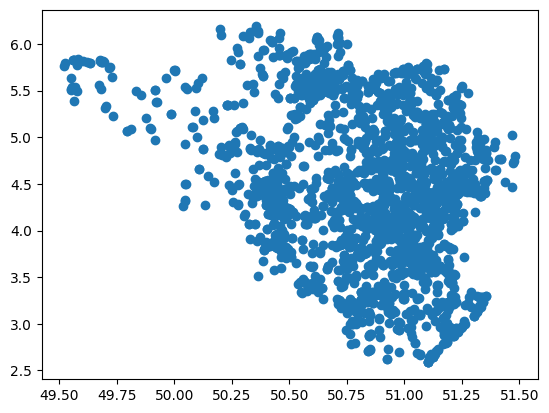

In [18]:
plt.scatter(x=data_points[:, 0], y= data_points[:, 1])

In [6]:
data_points.shape, class_member_mask.shape, len(cluster_centers)

((10000, 2), (10000,), 848)

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))
data_points = interventions_df.loc[
        :, ["latitude_intervention", "longitude_intervention"]
    ].to_numpy()
# Get unique labels (excluding noise points)

unique_labels = set(labels) - {-1}

# Define colors for clusters
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)

    xy = np.array(data_points)[class_member_mask]
    plt.plot(xy[:, 1], xy[:, 0], '.', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('DBSCAN Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3000 but corresponding boolean dimension is 207

<Figure size 1000x800 with 0 Axes>

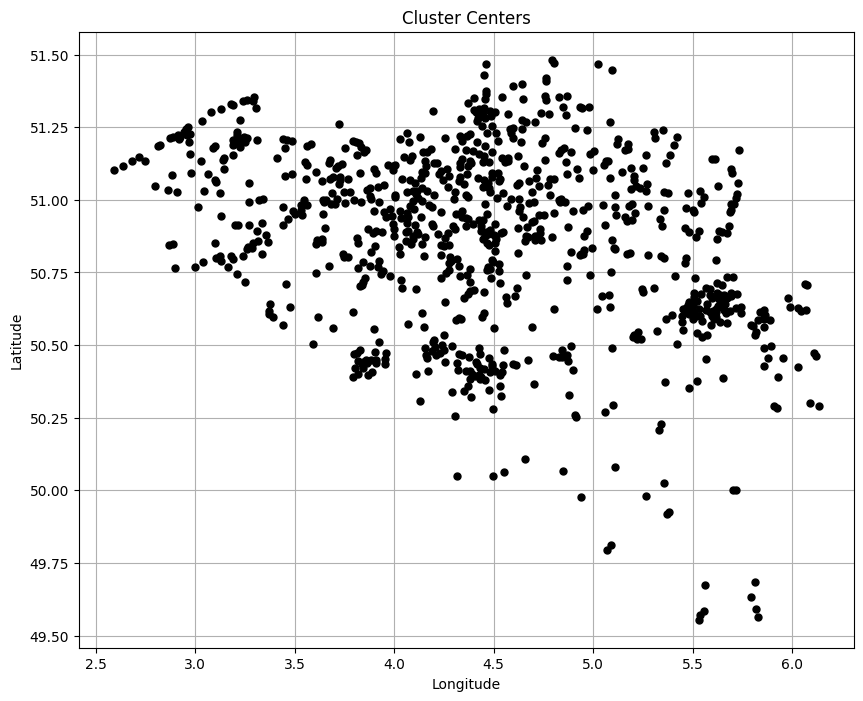

In [24]:

# Get unique labels (excluding noise points)
unique_labels = set(labels) - {-1}

# Initialize an empty list to store the cluster centers
cluster_centers = []

# Compute the centroid of each cluster
for label in unique_labels:
    class_member_mask = (labels == label)
    cluster_points = np.array(data_points)[class_member_mask]
    cluster_center = np.mean(cluster_points, axis=0)
    cluster_centers.append(cluster_center)

# Plotting
plt.figure(figsize=(10, 8))

# Plot the cluster centers
for cluster_center in cluster_centers:
    plt.plot(cluster_center[1], cluster_center[0], '.', markerfacecolor='black', markeredgecolor='k', markersize=10)

plt.title('Cluster Centers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [71]:
# address_counts = aed_locations_df['address'].value_counts()
# address_counts.index = address_counts.index.map(lambda x: x[:12] + '...' if len(x) > 16 else x)
# top_20_address_counts = address_counts.head(20)

# plt.figure(figsize=(12, 6))
# sns.barplot(x=top_20_address_counts.index, y=top_20_address_counts.values)
# plt.title('')
# plt.xlabel('Address')
# plt.ylabel('Count')
# plt.xticks(rotation=70)
# plt.tight_layout()
# plt.show()

In [78]:
class U_node:
    def __init__(self, id, latitude, longitude, type="aed"):
        self.id = id
        self.latitude = latitude
        self.longitude = longitude
        self.type = type
        
        if type=="aed":
            self.range = 3  # in km
    
    def __str__(self):
        return f"id: {self.id} | {self.type} at {self.latitude}, {self.longitude} with range {self.range}"
    
    def __repr__(self):
        return f"{self.__class__.__name__} (id={self.id})"
    
    
class V_node:
    def __init__(self, id, latitude, longitude, events_count):
        self.id = id
        self.latitude = latitude
        self.longitude = longitude
        self.events_count = events_count
        self._connected_u_nodes = []
        if type == "aed":
            self.range = 1000
            
    def add_connected_u_node(self, u_node, distance):
        if u_node not in self._connected_u_nodes and u_node.range >= distance:
            self._connected_u_nodes.append((u_node, distance))
            
    # @property
    # def connected_u_nodes(self):
    #     return self._connected_u_nodes
    
    # @connected_u_nodes.setter
    # def connected_u_nodes(self, connected_u_nodes):
    #         self._connected_u_nodes = connected_u_nodes
            
    def get_edges_for_nx(self):
        return [(self, *u_node_tuple) for u_node_tuple in self.connected_u_nodes]
    
    def __repr__(self):
        return f"{self.__class__.__name__} (id={self.id})"
    
    def __str__(self):
        return f"id: {self.id} | at {self.latitude}, {self.longitude} with {self.events_count} events"


    

In [79]:
label, points_count = np.unique(labels, return_counts=True)
label, points_count = label[1:], points_count[1:]  # removing -1 cluster (noise)

In [80]:
import networkx as nx
import math
from sklearn.cluster import DBSCAN


def euclidean_distance(lat0, long0, lat1, long1):

    lat_conversion_factor = 111.32  # km per degree latitude
    long_conversion_factor = (
        40075 * math.cos(math.radians((lat0 + lat1) / 2)) / 360
    )  # km per degree longitude

    # Convert latitude and longitude differences to kilometers
    dlat = (lat1 - lat0) * lat_conversion_factor
    dlong = (long1 - long0) * long_conversion_factor

    # Euclidean distance in kilometers
    distance = math.sqrt(dlat**2 + dlong**2)

    return distance


def cluster_interventions(df, eps=0.0001, min_samples=5, plot_cluster_centers=False):
    data_points = (
        df.loc[:, ["latitude intervention", "longitude intervention"]]
        .sample(n=20000, replace=False)  # TODO
        .to_numpy()
    )

    db = DBSCAN(eps=eps, min_samples=min_samples, metric="haversine").fit(
        np.radians(data_points)
    )

    labels = db.labels_
    unique_labels = set(labels) - {-1}
    cluster_centers = []

    for label in unique_labels:
        class_member_mask = labels == label
        cluster_points = np.array(data_points)[class_member_mask]
        cluster_center = np.mean(cluster_points, axis=0)
        cluster_centers.append(cluster_center)

    labels, point_counts = np.unique(labels, return_counts=True)
    labels, point_counts = labels[1:], point_counts[1:]  # removing -1 cluster (noise)

    if plot_cluster_centers:

        plt.figure(figsize=(10, 8))
        for cluster_center in cluster_centers:
            plt.plot(
                cluster_center[1],
                cluster_center[0],
                ".",
                markerfacecolor="black",
                markeredgecolor="k",
                markersize=10,
            )

        plt.title("Cluster Centers")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.grid(True)
        plt.show()

    return cluster_centers, labels, point_counts


cluster_centers, labels, point_counts = cluster_interventions(interventions_df)

In [81]:
def get_list_of_u_nodes(df):  # aed df
    U = []
    for _, row in df.iterrows():
        node = U_node(int(row["id"]), row["latitude"], row["longitude"], type="aed")
        U.append(node)
        
    return U
    
    
def get_list_of_v_nodes(cluster_centers, labels, point_counts):  # numpy array output from cluster_interventions
    V = []
    for idx, current_label in enumerate(labels):
        node = V_node(
            id=current_label,
            latitude=cluster_centers[idx][0],
            longitude=cluster_centers[idx][1],
            events_count=point_counts[idx],
        )
        V.append(node)

    return V

U = get_list_of_u_nodes(aed_df)
V = get_list_of_v_nodes(cluster_centers, labels, point_counts)


In [84]:
def create_graph(U, V, save_graph=None):

    G = nx.Graph()
    G.add_nodes_from(U, bipartite=0)
    G.add_nodes_from(V, bipartite=1)

    edges = []
    for u_node in U:
        for v_node in V:
            distance = euclidean_distance(
                u_node.latitude,
                u_node.longitude,
                v_node.latitude,
                v_node.longitude,
            )

            v_node.add_connected_u_node(u_node, distance)

            if u_node.range >= distance:
                edges.append((v_node, u_node, distance))
            # edges += v_node.get_edges_for_nx()

    G.add_weighted_edges_from(edges)
    
    if save_graph:
        nx.write_graphml(G, f"{save_graph}.graphml")  # TODO
        nx.write_gexf(G, f"{save_graph}.gexf")

    return G


G = create_graph(U, V, "someGraph")

list_of_v_nodes = {node for node, data in G.nodes(data=True) if data["bipartite"] == 1}
v_node_degrees = {node: G.degree(node) for node in list_of_v_nodes}

In [99]:
def merge_degrees_event_count(list_of_nodes, dict_of_degrees):
    temp_list = []
    for idx, v in enumerate(list_of_nodes):
        temp_list.append(
            [dict_of_degrees.get(V[v.id]), v.events_count]
        )
        
    merged_array = np.array(temp_list)  # 2-dim array: in-degree, events_count
    merged_array = merged_array[:, 1] / merged_array[:, 0]
    merged_array[np.isinf(merged_array)] = 999
    
    return merged_array
    
    
m = merge_degrees_event_count(V, v_node_degrees)

/tmp/ipykernel_1028172/1501254942.py:9: RuntimeWarning: divide by zero encountered in divide
  merged_array = merged_array[:, 1] / merged_array[:, 0]


In [101]:
class Objective_function:
    def __init__(self, alpha):
        self.alpha = alpha
        
    def __call__(self, G, count_over_degree):
        total_weight_sum = sum(weight for _, _, weight in G.edges(data="weight"))
        mean_edge_weight = total_weight_sum / G.number_of_edges()
        return (self.alpha * count_over_degree.mean()) + ((1 - self.alpha) * mean_edge_weight)


objective_function = Objective_function(alpha=0.5)

objective_function(G, m)

20.78909945826237

In [94]:
def main():
    
    #  aed_df, interventions_df = load_data(root_dir)
    
    objective_function = Objective_function(alpha=0.5)
    cluster_centers, labels, point_counts = cluster_interventions(interventions_df)
    U = get_list_of_u_nodes(aed_df)
    V = get_list_of_v_nodes(cluster_centers, labels, point_counts)
    
    G = create_graph(U, V, "someGraph")
    list_of_v_nodes = {node for node, data in G.nodes(data=True) if data["bipartite"] == 1}
    v_node_degrees = {node: G.degree(node) for node in list_of_v_nodes}
    m = merge_degrees_event_count(V, v_node_degrees)
    
    objective_function(G, m)
    

(14148, 12)

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [28]:
from create_graph import (
    load_data,
    Objective_function,
    cluster_interventions,
    get_list_of_u_nodes,
    get_list_of_v_nodes,
    create_graph,
    merge_degrees_event_count,
)
from preprocess import load_data
from utilities import random_coordinates_belgium, add_sampled_cooridnates_to_df

# ---------- Same throughout sampling ---------- #
aed_df, interventions_df = load_data(root_dir="../../data/")
aed_df = aed_df.sample(200)  # TODO
objective_function = Objective_function(alpha=0.5)

# ----------- DBSCAN ----------- #

interventions_np = (
    interventions_df.loc[:, ["latitude_intervention", "longitude_intervention"]]
    .sample(2000)
    .to_numpy()
)

data_points = interventions_np

eps = 0.0001
min_samples = 3 
print(data_points.shape)
db = DBSCAN(eps=eps, min_samples=min_samples, metric='haversine').fit(np.radians(data_points))

labels = db.labels_
unique_labels = set(labels) - {-1}

cluster_centers = []
for label in unique_labels:
    class_member_mask = (labels == label)
    cluster_points = np.array(data_points)[class_member_mask]
    cluster_center = np.mean(cluster_points, axis=0)
    cluster_centers.append(cluster_center)

labels, point_counts = np.unique(labels, return_counts=True)
labels, point_counts = labels[1:], point_counts[1:]  # removing -1 cluster (noise)

# ------------------------------- #

V = get_list_of_v_nodes(
    cluster_centers=cluster_centers, labels=labels, point_counts=point_counts
)

# ------------------- Step 0 ------------------- #

U = get_list_of_u_nodes(df=aed_df)
G = create_graph(U, V, "graph_000")
list_of_v_nodes = {node for node, data in G.nodes(data=True) if data["bipartite"] == 1}
v_node_degrees = {node: G.degree(node) for node in list_of_v_nodes}
m = merge_degrees_event_count(V, v_node_degrees)
loss_0 = objective_function(G, m)
print(f"U length: {len(U)}")
print(aed_df.iloc[-1, :])
print(loss_0)

(2000, 2)
U length: 200
id                       2723.0
type                        NaN
address            Bruggestraat
number                     14.0
postal_code                8820
municipality            Torhout
province        West-Vlaanderen
public                      NaN
available                   NaN
hours                       NaN
latitude              51.068602
longitude              3.102737
Name: 2277, dtype: object
14.14994798971571


In [30]:
# ------------------- Step 1 ------------------- #
best_graph = None
best_coordinates = None
best_loss = loss_0
sampling_count = 2
number_of_units_to_add = 5

for i in range(number_of_units_to_add):
    
    for j in range(sampling_count):
        latitude_sampled, longitude_sampled = random_coordinates_belgium()
        aed_with_sample_df = add_sampled_cooridnates_to_df(
            df=aed_df,
            id=100000+j,
            latitude=latitude_sampled,
            longitude=longitude_sampled,  # TODO fix the starting idx for samples
        )
        U = get_list_of_u_nodes(aed_with_sample_df)
        print(f"U length: {len(U)}")
        print()
        print(aed_with_sample_df.iloc[-1,:])

        print(len(U))
        G = create_graph(U, V, "graph_001")
        list_of_v_nodes = {node for node, data in G.nodes(data=True) if data["bipartite"] == 1}
        v_node_degrees = {node: G.degree(node) for node in list_of_v_nodes}
        m = merge_degrees_event_count(V, v_node_degrees)
        loss_iter = objective_function(G, m)
        print(loss_iter)
        
        if loss_iter <= best_loss:
            best_graph = G
            best_coordinates = (latitude_sampled, longitude_sampled)
            best_loss = loss_iter
            aed_df = aed_with_sample_df.copy(deep=True)
        

U length: 201

id               100000.0
type                  NaN
address               NaN
number                NaN
postal_code          <NA>
municipality          NaN
province              NaN
public                NaN
available             NaN
hours                 NaN
latitude        51.067864
longitude        5.922067
Name: 200, dtype: object
201
14.14994798971571
U length: 202

id               100001.0
type                  NaN
address               NaN
number                NaN
postal_code          <NA>
municipality          NaN
province              NaN
public                NaN
available             NaN
hours                 NaN
latitude        50.883746
longitude        4.220489
Name: 201, dtype: object
202
14.15331629355461
U length: 202

id               100000.0
type                  NaN
address               NaN
number                NaN
postal_code          <NA>
municipality          NaN
province              NaN
public                NaN
available             NaN
hou

In [5]:
loss_0

15.701048018122524

In [96]:
import random


def random_coordinates_belgium():
    # Define the boundaries of Belgium
    min_lat, max_lat = 50.6, 51.5
    min_long, max_long = 2.5, 6.5

    # Generate random latitude and longitude within the boundaries
    latitude = random.uniform(min_lat, max_lat)
    longitude = random.uniform(min_long, max_long)

    return latitude, longitude


def add_sampled_cooridnates_to_df(df, id, latitude, longitude):
    new_row = pd.Series({"id": id, "latitude": latitude, "longitude": longitude})

    df_temp = df.copy(deep=True)
    return pd.concat([df_temp, pd.DataFrame([new_row])], ignore_index=True)


latitude_sampled, longitude_sampled = random_coordinates_belgium()
aed_with_sample_df = add_sampled_cooridnates_to_df(
    df=aed_df,
    id=100000,
    latitude=latitude_sampled,
    longitude=longitude_sampled,  # TODO fix the starting idx for samples
)

aed_with_sample_df.tail()

,id,type,address,number,postal_code,municipality,province,public,available,hours,latitude,longitude
14144,16515.0,Appareil Fixe-Vast Apparaat,Rue Pierre Victor Jacobs,17.0,1080,Molenbeek-Saint-Jean,NaN,Yes,No,NaN,50.863358,4.339750
14145,16516.0,Appareil Fixe-Vast Apparaat,Quai Du Hainaut,69.0,1080,Molenbeek-Saint-Jean,NaN,Yes,No,NaN,50.850272,4.336024
14146,16517.0,Appareil Fixe-Vast Apparaat,Rue De Jerusalem,56.0,1030,Schaerbeek,NaN,Yes,No,NaN,50.865428,4.378332
14147,16518.0,Appareil Fixe-Vast Apparaat,Rue De Jerusalem,56.0,1030,Schaerbeek,NaN,Yes,No,NaN,50.865428,4.378332
14148,100000.0,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,51.262086,5.043380


In [159]:
create_graph(df_with_sampled_coordinates)

,id,type,address,number,postal_code,municipality,province,public,available,hours,latitude,longitude
3,71.0,NaN,Place Saint - Lambert,NaN,4020,Liège,Liège,NaN,NaN,NaN,50.645185,5.574293
4,72.0,NaN,Rue Du Doyard,NaN,4990,Lierneux,Liège,NaN,NaN,NaN,50.285641,5.780870
5,73.0,NaN,Fond Saint Servais,NaN,4000,Liège,Liège,NaN,NaN,NaN,50.647276,5.570219
6,73.0,NaN,Fond Saint Servais,NaN,4000,Liège,Liège,NaN,NaN,NaN,50.647276,5.570219
7,74.0,NaN,Rue Des Prémontrès,12.0,4020,Liège,Liège,NaN,NaN,NaN,50.638047,5.574046
...,...,...,...,...,...,...,...,...,...,...,...,...
17196,16514.0,Appareil Fixe-Vast Apparaat,Avenue Du Vert Chasseur,46.0,1180,Uccle,NaN,Yes,No,NaN,50.799814,4.370103
17197,16515.0,Appareil Fixe-Vast Apparaat,Rue Pierre Victor Jacobs,17.0,1080,Molenbeek-Saint-Jean,NaN,Yes,No,NaN,50.863358,4.339750
17198,16516.0,Appareil Fixe-Vast Apparaat,Quai Du Hainaut,69.0,1080,Molenbeek-Saint-Jean,NaN,Yes,No,NaN,50.850272,4.336024
17199,16517.0,Appareil Fixe-Vast Apparaat,Rue De Jerusalem,56.0,1030,Schaerbeek,NaN,Yes,No,NaN,50.865428,4.378332


In [143]:
# import networkx as nx

# # Assuming G is your network graph
# # Calculate the total weight sum
# total_weight_sum = sum(weight for _, _, weight in G.edges(data='weight'))

# # Calculate the mean edge weight
# mean_edge_weight = total_weight_sum / G.number_of_edges()

# # Normalize the mean edge weight (optional)
# # You can divide by the maximum possible edge weight if you want to normalize it to a range of [0, 1]
# max_edge_weight = max(weight for _, _, weight in G.edges(data='weight'))
# normalized_mean_edge_weight = mean_edge_weight / max_edge_weight

# print("Mean edge weight:", mean_edge_weight)
# print("Normalized mean edge weight:", normalized_mean_edge_weight)


Mean edge weight: 1.7445507971592231
Normalized mean edge weight: 0.5815318408572137


In [147]:
def objective_function(count_over_degree, G, alpha=0.5):
    total_weight_sum = sum(weight for _, _, weight in G.edges(data="weight"))
    mean_edge_weight = total_weight_sum / G.number_of_edges()
    return (alpha * count_over_degree.mean()) + ((1 - alpha) * mean_edge_weight)


objective_function(m, G)

18.875486641983827

In [135]:
temp_list = []
for idx, v in enumerate(V):
    temp_list.append(
        [degrees_second_set.get(V[v.id]), v.events_count]
    )
    
temp_array = np.array(temp_list)  # 2-dim array: in-degree, events_count
array = temp_array[:, 1] / temp_array[:, 0]
array[np.isinf(array)] = 999


/tmp/ipykernel_996997/574870220.py:8: RuntimeWarning:

divide by zero encountered in divide



In [ ]:
## TODO IF ENOUGH TIME

# import random
# import json
# from shapely.geometry import Point, Polygon

# def load_geojson(filename):
#     with open(filename, 'r') as f:
#         data = json.load(f)
#     return data

# def random_location_belgium(geojson_filename):
#     # Load Belgium GeoJSON data
#     belgium_data = load_geojson(geojson_filename)
    
#     # Extract the polygon representing the boundaries of Belgium
#     belgium_polygon = Polygon(belgium_data['features'][0]['geometry']['coordinates'][0])
    
#     # Keep sampling until we find a point within Belgium
#     while True:
#         # Generate random latitude and longitude
#         latitude = random.uniform(49.5, 51.5)  # Roughly covering Belgium
#         longitude = random.uniform(2.5, 6.5)    # Roughly covering Belgium
        
#         # Create a point from the latitude and longitude
#         point = Point(longitude, latitude)
        
#         # Check if the point is within Belgium
#         if belgium_polygon.contains(point):
#             return latitude, longitude

# # Example usage:
# geojson_filename = "belgium.geojson"  # Replace with the path to your Belgium GeoJSON file
# latitude, longitude = random_location_belgium(geojson_filename)
# print("Random location in Belgium:")
# print("Latitude:", latitude)
# print("Longitude:", longitude)


Random location in Belgium:
Latitude: 50.667847224061134
Longitude: 4.042470782306188


(array([688.,   3.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         25.]),
 array([2.38095238e-02, 1.00135714e+01, 2.00033333e+01, 2.99930952e+01,
        3.99828571e+01, 4.99726190e+01, 5.99623810e+01, 6.99521429e+01,
        7.99419048e+01, 8.99316667e+01, 9.99214286e+01, 1.09911190e+02,
        1.19900952e+02, 1.29890714e+02, 1.39880476e+02, 1.49870238e+02,
        1.59860000e+02, 1.6984

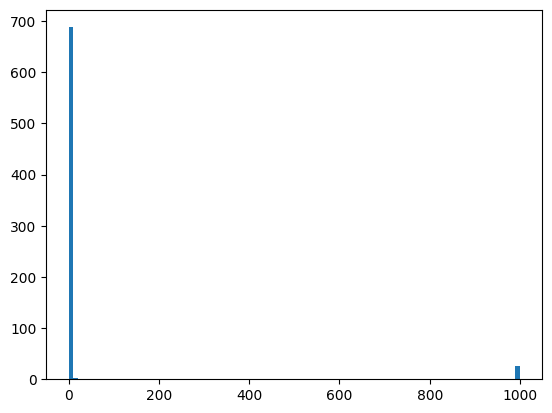

In [138]:
plt.hist(array, bins=100)

In [83]:
G.nodes()

NodeView((U_node (id=71), U_node (id=72), U_node (id=73), U_node (id=73), U_node (id=74), U_node (id=75), U_node (id=76), U_node (id=77), U_node (id=78), U_node (id=78), U_node (id=79), U_node (id=86), U_node (id=86), U_node (id=87), U_node (id=95), U_node (id=96), U_node (id=100), U_node (id=101), U_node (id=102), U_node (id=111), U_node (id=115), U_node (id=116), U_node (id=117), U_node (id=118), U_node (id=118), U_node (id=119), U_node (id=120), U_node (id=120), U_node (id=170), U_node (id=219), U_node (id=219), U_node (id=221), U_node (id=222), U_node (id=222), U_node (id=223), U_node (id=223), U_node (id=224), U_node (id=225), U_node (id=228), U_node (id=229), U_node (id=230), U_node (id=231), U_node (id=232), U_node (id=233), U_node (id=233), U_node (id=238), U_node (id=239), U_node (id=240), U_node (id=242), U_node (id=275), U_node (id=277), U_node (id=282), U_node (id=310), U_node (id=311), U_node (id=312), U_node (id=313), U_node (id=315), U_node (id=315), U_node (id=316), U_n

In [103]:
G.edges()

EdgeView([(U_node (id=71), V_node (id=9)), (U_node (id=73), V_node (id=9)), (U_node (id=73), V_node (id=9)), (U_node (id=74), V_node (id=9)), (U_node (id=77), V_node (id=9)), (U_node (id=78), V_node (id=9)), (U_node (id=78), V_node (id=9)), (U_node (id=79), V_node (id=9)), (U_node (id=87), V_node (id=10)), (U_node (id=96), V_node (id=563)), (U_node (id=100), V_node (id=50)), (U_node (id=102), V_node (id=60)), (U_node (id=111), V_node (id=223)), (U_node (id=111), V_node (id=239)), (U_node (id=111), V_node (id=286)), (U_node (id=111), V_node (id=562)), (U_node (id=111), V_node (id=576)), (U_node (id=115), V_node (id=194)), (U_node (id=115), V_node (id=631)), (U_node (id=115), V_node (id=693)), (U_node (id=170), V_node (id=43)), (U_node (id=170), V_node (id=492)), (U_node (id=219), V_node (id=9)), (U_node (id=219), V_node (id=9)), (U_node (id=221), V_node (id=105)), (U_node (id=221), V_node (id=269)), (U_node (id=221), V_node (id=304)), (U_node (id=222), V_node (id=201)), (U_node (id=222)

In [105]:
nx.write_gexf(G, "graph.gexf")

# Write to GraphML - Also widely used in Gephi
nx.write_graphml(G, "graph.graphml")

In [57]:
v_node._connected_u_nodes

[]

In [191]:
V[622].get_edges_for_nx()

[(id: 622 | at 50.613, 5.588791428571428 with 7 events,
  id: 840 | aed at 50.617906, 5.5901096112788 with range 2),
 (id: 622 | at 50.613, 5.588791428571428 with 7 events,
  id: 1170 | aed at 50.61123685, 5.602807452534967 with range 2),
 (id: 622 | at 50.613, 5.588791428571428 with 7 events,
  id: 1170 | aed at 50.61123685, 5.602807452534967 with range 2),
 (id: 622 | at 50.613, 5.588791428571428 with 7 events,
  id: 1191 | aed at 50.6171101, 5.5953751 with range 2),
 (id: 622 | at 50.613, 5.588791428571428 with 7 events,
  id: 1192 | aed at 50.61407285, 5.603893566126709 with range 2),
 (id: 622 | at 50.613, 5.588791428571428 with 7 events,
  id: 1210 | aed at 50.63029525, 5.5825828044945975 with range 2),
 (id: 622 | at 50.613, 5.588791428571428 with 7 events,
  id: 1337 | aed at 50.61904155, 5.5769536057599005 with range 2),
 (id: 622 | at 50.613, 5.588791428571428 with 7 events,
  id: 1337 | aed at 50.61904155, 5.5769536057599005 with range 2),
 (id: 622 | at 50.613, 5.5887914285

(array([ 7.,  8., 13.,  7.,  6., 13., 10., 14., 14.,  9., 11., 15., 16.,
        14., 17., 29., 20., 24., 22., 27., 31., 39., 26., 35., 26., 28.,
        17., 25., 22., 15., 12., 15., 12.,  3., 10.,  8., 11., 10., 11.,
        12., 10., 10.,  5.,  5.,  6.,  3.,  3.,  5.,  4.,  4.]),
 array([  1.78999942,   6.09271287,  10.39542633,  14.69813978,
         19.00085324,  23.3035667 ,  27.60628015,  31.90899361,
         36.21170707,  40.51442052,  44.81713398,  49.11984743,
         53.42256089,  57.72527435,  62.0279878 ,  66.33070126,
         70.63341472,  74.93612817,  79.23884163,  83.54155508,
         87.84426854,  92.146982  ,  96.44969545, 100.75240891,
        105.05512236, 109.35783582, 113.66054928, 117.96326273,
        122.26597619, 126.56868965, 130.8714031 , 135.17411656,
        139.47683001, 143.77954347, 148.08225693, 152.38497038,
        156.68768384, 160.99039729, 165.29311075, 169.59582421,
        173.89853766, 178.20125112, 182.50396458, 186.80667803,
        191.

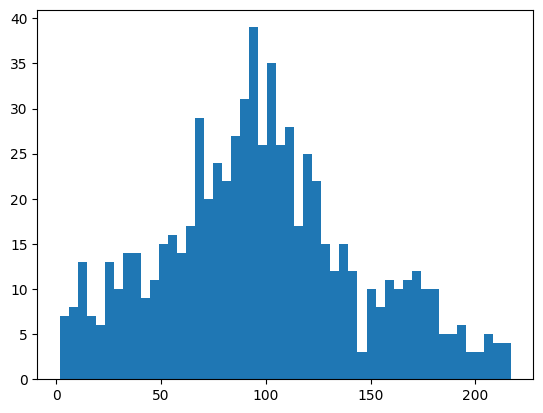

In [149]:
plt.hist(sorted(l), bins=50)

In [ ]:
import math

def haversine_distance(lat0, long0, lat1, long1):

    lat0, long0, lat1, long1 = map(math.radians, [lat0, long0, lat1, long1])

    # Haversine formula
    dlat = lat1 - lat0
    dlong = long1 - long0
    a = math.sin(dlat / 2)**2 + math.cos(lat0) * math.cos(lat1) * math.sin(dlong / 2)**2
    c = 2 * math.asin(math.sqrt(a))

    # Radius of Earth in kilometers. Use 3956 for miles.
    r = 6371

    # Calculate the distance
    distance = c * r

    return distance

# Example usage
lat0, long0 = 52.2296756, 21.0122287  # Warsaw, Poland
lat1, long1 = 41.8919300, 12.5113300  # Rome, Italy
distance = haversine_distance(lat0, long0, lat1, long1)
print(f"Distance: {distance} km")


Distance: 41.241815816960546 km


In [ ]:
plt.hist(sorted(l), bins=50)

In [100]:
df.head()

,id,type,address,number,postal_code,municipality,province,public,available,hours,latitude,longitude
3,71.0,NaN,Place Saint - Lambert,NaN,4020,Liège,Liège,NaN,NaN,NaN,50.645185,5.574293
4,72.0,NaN,Rue Du Doyard,NaN,4990,Lierneux,Liège,NaN,NaN,NaN,50.285641,5.780870
5,73.0,NaN,Fond Saint Servais,NaN,4000,Liège,Liège,NaN,NaN,NaN,50.647276,5.570219
6,73.0,NaN,Fond Saint Servais,NaN,4000,Liège,Liège,NaN,NaN,NaN,50.647276,5.570219
7,74.0,NaN,Rue Des Prémontrès,12.0,4020,Liège,Liège,NaN,NaN,NaN,50.638047,5.574046


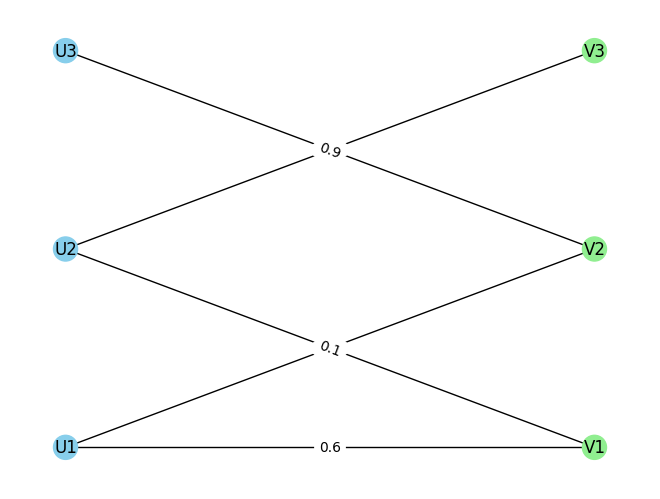

In [83]:
import networkx as nx
import matplotlib.pyplot as plt



# Create instances of Node with attributes
U = [Node('U1', 'attr1'), Node('U2', 'attr2'), Node('U3', 'attr3')]
V = [Node('V1', 'attrA'), Node('V2', 'attrB'), Node('V3', 'attrC')]

# Create a bipartite graph
B = nx.Graph()

# Add nodes with the bipartite attribute and additional attributes
for u in U:
    B.add_node(u, bipartite=0, attribute=u.attribute)
for v in V:
    B.add_node(v, bipartite=1, attribute=v.attribute)

# Add edges with weights
edges = [
    (U[0], V[0], 0.6), 
    (U[0], V[1], 0.2), 
    (U[1], V[0], 0.1), 
    (U[1], V[2], 0.7), 
    (U[2], V[1], 0.9)
]
B.add_weighted_edges_from(edges)

# Draw the graph
pos = {node: (0, i) for i, node in enumerate(U)}
pos.update({node: (1, i) for i, node in enumerate(V)})
nx.draw(B, pos, with_labels=True, labels={node: node.name for node in U+V}, node_color=['skyblue']*len(U) + ['lightgreen']*len(V))

# Draw edge labels with weights
edge_labels = {(u, v): w for u, v, w in edges}
nx.draw_networkx_edge_labels(B, pos, edge_labels=edge_labels)

plt.show()



In [ ]:
aed_locations_df

In [ ]:
_ = [
    print(x)
    for x in aed_locations_df[~aed_locations_df["address"].isna()]["address"].unique()
]

In [ ]:
_ = [
    print(x)
    for x in aed_locations_df[~aed_locations_df["location"].isna()]["location"].unique()
]

In [ ]:
aed_locations_df[~aed_locations_df['available'].isna()]['available'].unique()

In [ ]:
medical_transport_path = root_dir + 'raw/medical_transport/'

ambulance_locations = pq.read_table(medical_transport_path + 'ambulance_locations.parquet.gzip') 
ambulance_locations_df = ambulance_locations.to_pandas()

pit_locations = pq.read_table(medical_transport_path + 'pit_locations.parquet.gzip')
pit_locations_df = pit_locations.to_pandas()

mug_locations = pq.read_table(medical_transport_path + 'mug_locations.parquet.gzip')
mug_locations_df = mug_locations.to_pandas()

In [ ]:
ambulance_locations_df.head()

In [ ]:
ambulance_locations_counts = ambulance_locations_df['departure_location'].value_counts()
ambulance_locations_counts.index = ambulance_locations_counts.index.map(lambda x: x[:12] + '...' if len(x) > 16 else x)
top_20_ambulance_locations_counts = ambulance_locations_counts.head(80)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_20_ambulance_locations_counts.index, y=top_20_ambulance_locations_counts.values)
plt.title('')
plt.xlabel('departure_location')
plt.ylabel('Count')
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

In [ ]:
!ls -la ../


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import contextily as ctx

In [ ]:
!ls -la "../../data/raw/maps/"

In [ ]:
df

In [ ]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/fips-unemp-16.csv",
                   dtype={"fips": str})

import plotly.express as px

fig = px.choropleth_mapbox(df, geojson=counties, locations='fips', color='unemp',
                           color_continuous_scale="Viridis",
                           range_color=(0, 12),
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'unemp':'unemployment rate'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
data_dir = "../../data/raw/maps/"
path_rg = data_dir + "NUTS_RG_20M_2021_3035.shp"
gdf_rg = gpd.read_file(path_rg)
# path_bn = data_dir + "NUTS_BN_01M_2021_3035_LEVL_0.shp"
# gdf_bn = gpd.read_file(path_bn)
# path_lb = data_dir + "NUTS_LB_2021_3035_LEVL_0.shp"
# gdf_lb = gpd.read_file(path_lb)


gdf_rg_belgium = gdf_rg[gdf_rg.CNTR_CODE == "BE"]
ax = gdf_rg_belgium.plot(figsize=(20,15), color="gray")
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing latitude and longitude columns

# Load the shapefile for Belgium
belgium_map = gpd.read_file("../../data/raw/maps/be_1km.shp")

gdf = gpd.GeoDataFrame(
    ambulance_locations_df,
    geometry=gpd.points_from_xy(
        ambulance_locations_df.longitude, ambulance_locations_df.latitude
    ),
)

# Plot the map of Belgium
fig, ax = plt.subplots(figsize=(10, 10))
belgium_map.plot(ax=ax, color="lightgrey")

# Plot the points on the map
gdf.plot(ax=ax, color="red", markersize=5)

plt.title("Points on Belgium Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing latitude and longitude columns

# Load the shapefile for Belgium
belgium_map = gpd.read_file("path_to_belgium_shapefile/belgium_shapefile.shp")

# Create a GeoDataFrame from the DataFrame with latitude and longitude
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# Plot the map of Belgium
fig, ax = plt.subplots(figsize=(10, 10))
belgium_map.plot(ax=ax, color='lightgrey')

# Plot the points on the map
gdf.plot(ax=ax, color='red', markersize=5)

plt.title('Points on Belgium Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:
pit_locations_df.head()

In [ ]:
mug_locations_df.head()

In [ ]:
pd.set_option('display.max_columns', None)


In [ ]:
interventions_path = root_dir + 'raw/interventions/'

interventions_bxl = pq.read_table(interventions_path + 'interventions_bxl.parquet.gzip') 
interventions_bxl_df = interventions_bxl.to_pandas()

interventions_bxl2 = pq.read_table(interventions_path + 'interventions_bxl2.parquet.gzip')
interventions_bxl_df = interventions_bxl2.to_pandas()

interventions1 = pq.read_table(interventions_path + 'interventions1.parquet.gzip')
interventions1_df = interventions1.to_pandas()

In [ ]:
interventions_bxl_df.head()

In [ ]:
interventions_bxl_df['Abandon reason FR'].unique()

In [ ]:
interventions1_df